In [1]:
import ml_eke
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
reload(ml_eke)

<module 'ml_eke' from '/lus/snx11254/ashao/dev/machine_learning_eke/ml_eke/__init__.py'>

In [2]:
class multimethod_prediction_model:
    from random import sample
    def __init__(self, X, Y, scaler = StandardScaler, regressors = {'LinearRegression':linear_model.LinearRegression()}):
        """A class that can be extended to use many types of regression methods
        :param X: Training data of the unscaled quantities for prediction
        :type X: 2D array [sample, feature]
        :param Y: Training data of the quantities to be predicted
        :type Y: 2D array [sample, feature]
        :param regressors: Labels and types of prediction models
        :type regressors: dict
        """
        self.X_unscaled = X
        self.Y_unscaled = Y
        
        self.X_scaler = scaler()
        self.X_scaler.fit(X)
        self.Y_scaler = scaler()
        self.Y_scaler.fit(Y)
        
        self.X_scaled = self.X_scaler.transform(X)
        self.Y_scaled = self.Y_scaler.transform(Y)
        
        self.regressors = regressors
        self.subsample = range(X.shape[0])
        
    def fit_regressor(self, regressor):
        """Fit a single regressor to the training data
        """
        self.regressors[regressor].fit(self.X_scaled[self.subsample,:], self.Y_scaled[self.subsample,:])
        
    def fit_all_regressors(self):
        """Fit all regressors to the training data
        """
        for regressor in self.regressors:
            self.fit_regressor(regressor)
    
    def regressor_predict(self, X, regressor, **kwargs):
        """Predict using a single model
        """
        return self.Y_scaler.inverse_transform(self.regressors[regressor].predict(X, **kwargs))
    
    def all_regressor_predict(self, X, X_is_scaled = True):
        """Predict using all models
        """
        if not X_is_scaled:
            X = self.X_scaler.transform(X)
        return { regressor:self.regressor_predict(X, regressor) for regressor in self.regressors }
    
    def set_subsample(self, subsample_idx):
        """Set the indices of the original to subsample for fitting
        """
        self.subsample = subsample_idx
    
    def set_random_subsample(self, nsub):
        self.set_subsample(shuffle(range(X.shape[0]))[:nsub])

In [3]:
datapath = '/home/users/ashao/snx11254/data/ncar/eke_param'
model_data = ml_eke.pop_data(f'{datapath}/INPUT_DATA',f'{datapath}/TRAINING_DATA')
X, Y, mask = model_data.extract_sample_from_time(predictands = ['EKE_vert_avg'], sample_idx = -1)
X2, Y2, mask = model_data.extract_sample_from_time(predictands = ['EKE_vert_avg'], sample_idx = 0)

regressors = {'LinearRegression':linear_model.LinearRegression(),
              'Lasso':linear_model.Lasso(0.1),
              'MLP':MLPRegressor()
             }
prediction_model = multimethod_prediction_model(X,Y,regressors=regressors)



/home/users/ashao/snx11254/data/ncar/eke_param/INPUT_DATA/gradU_file_0001.nc


In [4]:
prediction_model.fit_all_regressors()

/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
Y_predict = prediction_model.all_regressor_predict(X, X_is_scaled = False)
Y2_predict = prediction_model.all_regressor_predict(X2, X_is_scaled = False)

/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


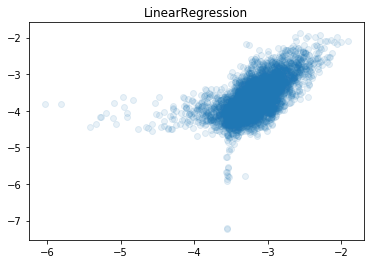

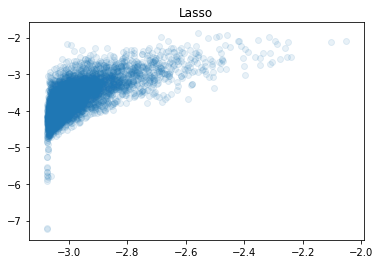

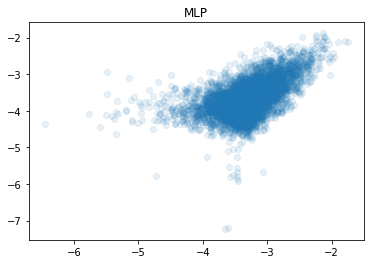

In [6]:
nsamp = range(5000)

for regressor in regressors:
#     s = Y2_predict[regressor][nsamp]-Y2[nsamp]*10
    plt.figure()
    plt.scatter(np.log10(Y_predict[regressor][nsamp]), np.log10(Y[nsamp]), alpha = 0.1)#, s = s)    
    plt.title(regressor)

In [51]:
training_data_pd = pd.DataFrame(  X,columns = list(model_data.predictors) )
training_data_pd['EKE_vert_avg'] = Y

validation_data_pd = pd.DataFrame(  X2, columns = list(model_data.predictors) )
validation_data_pd['EKE_vert_avg'] = Y2

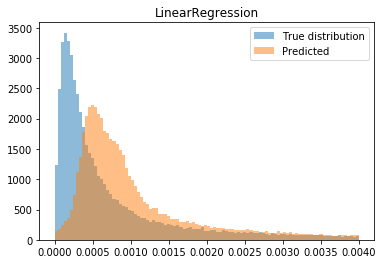

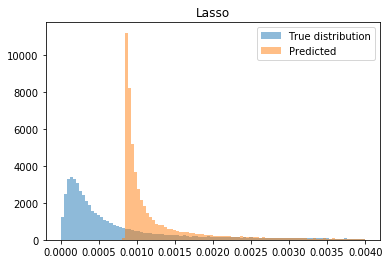

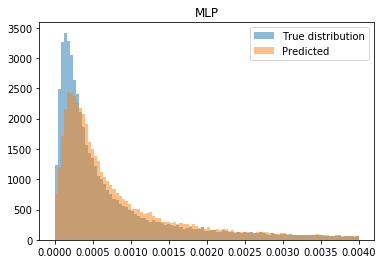

In [8]:
for regressor in regressors:
    plt.figure()
    plt.hist(np.log1p(Y2),range=[0,0.004],bins=100,alpha=0.5,label='True distribution');
    plt.hist(np.log1p(Y2_predict[regressor]),range = [0,0.004],bins=100,alpha=0.5,label='Predicted');
    plt.legend()
    plt.title(regressor)

In [52]:
training_data_pd.to_csv('training_data.csv')
validation_data_pd.to_csv('validation_data.csv')

/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


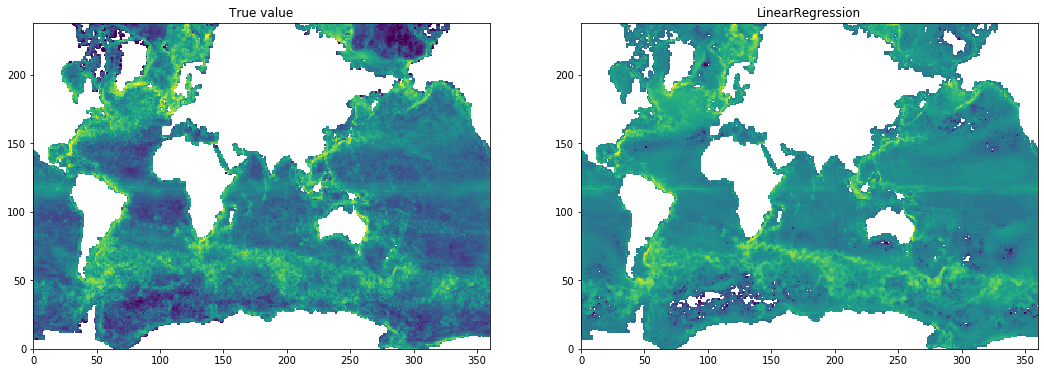

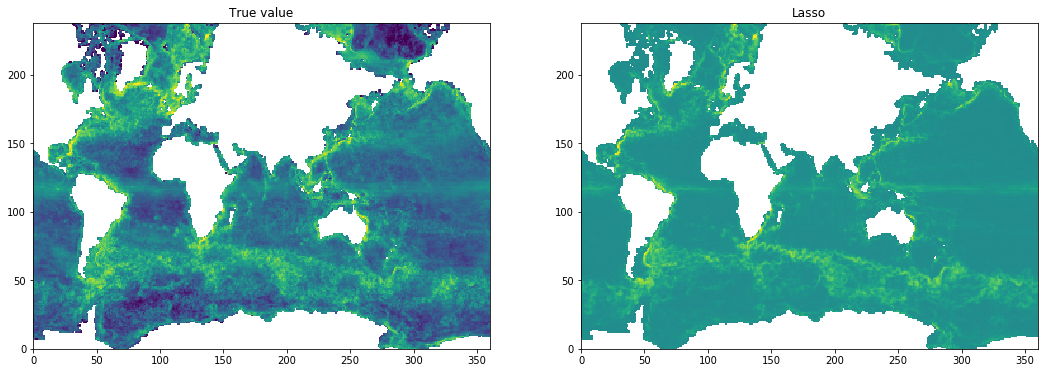

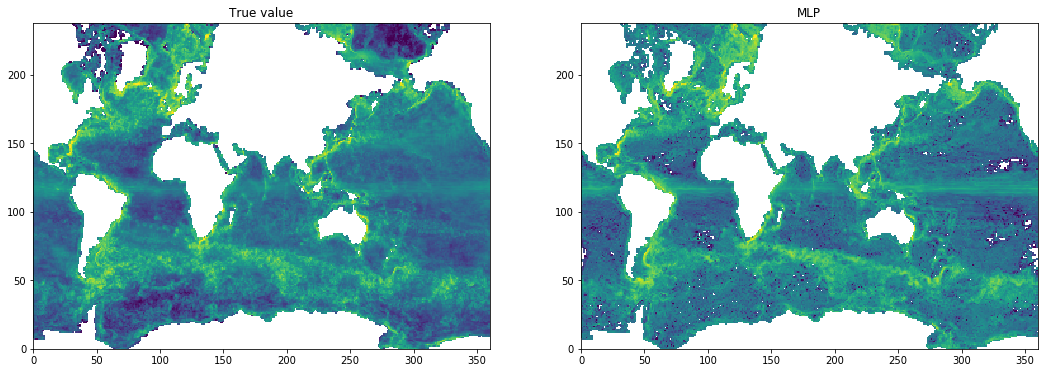

In [50]:
A = np.zeros([model_data.y.shape[0],model_data.x.shape[0]])
A_true = np.zeros([model_data.y.shape[0],model_data.x.shape[0]])
mask_2d = mask.reshape(A.shape)
A_true[mask_2d] = Y2.squeeze()

for regressor in regressors:
    A[mask_2d] = Y2_predict[regressor].squeeze()
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('True value')
    plt.pcolormesh(np.log10(A_true),vmin=-5,vmax=-1)
    plt.subplot(1,2,2)
    plt.title(regressor)
    plt.pcolormesh(np.log10(A),vmin=-5,vmax=-1)